# Gesture Recognition - Siddharth Parakh
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import os
from scipy.misc import *
#from scipy.misc import  imresize
import imageio
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
#!pip install imageio

In [8]:
#!pip install keras
!pip install tensorflow
#!pip install tensorflow==1.8.0

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [8]:
#!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [7]:
project_folder='Project_data'

##### Plotting

In [8]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
     
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open('train.csv').readlines())
        self.val_doc = np.random.permutation(open('val.csv').readlines())
        self.train_path = 'train'
        self.val_path =  'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized=cv2.resize(image, (self.image_height,self.image_width))
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name #+ 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        #history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps)
        
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [10]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

##### Sample Cropping

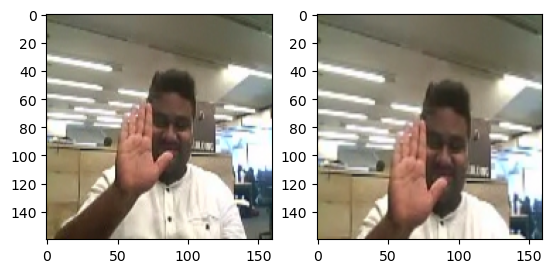

In [12]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [24]:
#sample 1
conv_3d1.train_model(conv_3d1_model)


Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 1/17 [>.............................] - ETA: 9:25 - loss: 2.3517 - categorical_accuracy: 0.1500
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 2/17 [==>...........................] - ETA: 8:32 - loss: 2.1402 - categorical_accuracy: 0.2375
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 3/17 [====>.........................] - ETA: 8:00 - loss: 1.9405 - categorical_accuracy: 0.3167
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 4/17 [======>.......................] - ETA: 7:20 - loss: 1.8244 - categorical_accuracy: 0.3562
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 5/17 [=======>......................] - ETA: 6:47 - loss: 1.7826 - categorical_accuracy: 0.3600
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 6/17 [=========>....................] - ETA: 6:15 - loss: 1.8504 - categorical_accuracy: 0.3625
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 7/17 [===========>..................] - ETA: 5:41 - loss: 1.8008 - categorical_accuracy: 0.3714
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 8/17 [=============>................] - ETA: 5:08 - loss: 1.7296 - categorical_accuracy: 0.3875
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


 9/17 [==============>...............] - ETA: 4:34 - loss: 1.6793 - categorical_accuracy: 0.4028
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


10/17 [================>.............] - ETA: 4:00 - loss: 1.6241 - categorical_accuracy: 0.4225
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


11/17 [==================>...........] - ETA: 3:26 - loss: 1.5823 - categorical_accuracy: 0.4318
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


12/17 [====================>.........] - ETA: 2:51 - loss: 1.5525 - categorical_accuracy: 0.4396
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


13/17 [=====================>........] - ETA: 2:17 - loss: 1.5356 - categorical_accuracy: 0.4462
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


14/17 [=======================>......] - ETA: 1:43 - loss: 1.5213 - categorical_accuracy: 0.4482
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


15/17 [=========================>....] - ETA: 1:08 - loss: 1.4793 - categorical_accuracy: 0.4633
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


16/17 [===========================>..] - ETA: 34s - loss: 1.4631 - categorical_accuracy: 0.4703 
Epoch 1: saving model to model_init_2023-05-1621_27_30.454050\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_27_30.454050\assets


17/17 [==============================] - 596s 35s/step - loss: 1.4521 - categorical_accuracy: 0.4751 - val_loss: 2.1400 - val_categorical_accuracy: 0.2100 - lr: 0.0010


### Resolution of 160x160 with 30 frames and batch_size of 40...we got 48% accuracy


In [25]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


So lets trade-off between these parameters.

Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [26]:
#sample 2
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3

Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 1/23 [>.............................] - ETA: 5:50 - loss: 2.3798 - categorical_accuracy: 0.2667
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 2/23 [=>............................] - ETA: 5:10 - loss: 2.3290 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 3/23 [==>...........................] - ETA: 4:57 - loss: 2.2430 - categorical_accuracy: 0.2667
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 4/23 [====>.........................] - ETA: 4:42 - loss: 2.1218 - categorical_accuracy: 0.2917
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 5/23 [=====>........................] - ETA: 4:27 - loss: 2.0112 - categorical_accuracy: 0.3200
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 6/23 [======>.......................] - ETA: 4:12 - loss: 1.9884 - categorical_accuracy: 0.3222
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 7/23 [========>.....................] - ETA: 3:57 - loss: 1.9012 - categorical_accuracy: 0.3429
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 8/23 [=========>....................] - ETA: 3:43 - loss: 1.8501 - categorical_accuracy: 0.3417
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 9/23 [==========>...................] - ETA: 3:28 - loss: 1.7763 - categorical_accuracy: 0.3667
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


10/23 [============>.................] - ETA: 3:13 - loss: 1.7675 - categorical_accuracy: 0.3667
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


11/23 [=============>................] - ETA: 2:58 - loss: 1.6934 - categorical_accuracy: 0.3909
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


12/23 [==============>...............] - ETA: 2:43 - loss: 1.6438 - categorical_accuracy: 0.4111
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


13/23 [===============>..............] - ETA: 2:28 - loss: 1.6029 - categorical_accuracy: 0.4231
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


14/23 [=================>............] - ETA: 2:13 - loss: 1.5693 - categorical_accuracy: 0.4381
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


15/23 [==================>...........] - ETA: 1:59 - loss: 1.5403 - categorical_accuracy: 0.4422
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


16/23 [===================>..........] - ETA: 1:44 - loss: 1.5457 - categorical_accuracy: 0.4417
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


17/23 [=====================>........] - ETA: 1:29 - loss: 1.5309 - categorical_accuracy: 0.4412
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


18/23 [======================>.......] - ETA: 1:14 - loss: 1.5103 - categorical_accuracy: 0.4500
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


19/23 [=======================>......] - ETA: 59s - loss: 1.5139 - categorical_accuracy: 0.4474 
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


20/23 [=========================>....] - ETA: 44s - loss: 1.4820 - categorical_accuracy: 0.4550
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


21/23 [==========================>...] - ETA: 29s - loss: 1.4565 - categorical_accuracy: 0.4651
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


22/23 [===========================>..] - ETA: 14s - loss: 1.4432 - categorical_accuracy: 0.4697
Epoch 1: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


23/23 [==============================] - 343s 15s/step - loss: 1.4426 - categorical_accuracy: 0.4691 - val_loss: 1.8222 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3

Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 1/23 [>.............................] - ETA: 5:28 - loss: 0.9929 - categorical_accuracy: 0.6667
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 2/23 [=>............................] - ETA: 5:11 - loss: 0.8118 - categorical_accuracy: 0.7167
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 3/23 [==>...........................] - ETA: 4:58 - loss: 1.0319 - categorical_accuracy: 0.6556
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 4/23 [====>.........................] - ETA: 4:42 - loss: 1.0273 - categorical_accuracy: 0.6333
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 5/23 [=====>........................] - ETA: 4:28 - loss: 0.9974 - categorical_accuracy: 0.6333
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 6/23 [======>.......................] - ETA: 4:13 - loss: 0.9839 - categorical_accuracy: 0.6333
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 7/23 [========>.....................] - ETA: 3:59 - loss: 0.9947 - categorical_accuracy: 0.6381
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 8/23 [=========>....................] - ETA: 3:44 - loss: 1.0293 - categorical_accuracy: 0.6417
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 9/23 [==========>...................] - ETA: 3:28 - loss: 1.0048 - categorical_accuracy: 0.6444
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


10/23 [============>.................] - ETA: 3:13 - loss: 1.0283 - categorical_accuracy: 0.6433
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


11/23 [=============>................] - ETA: 2:58 - loss: 1.0114 - categorical_accuracy: 0.6455
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


12/23 [==============>...............] - ETA: 2:44 - loss: 0.9991 - categorical_accuracy: 0.6389
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


13/23 [===============>..............] - ETA: 2:29 - loss: 0.9904 - categorical_accuracy: 0.6359
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


14/23 [=================>............] - ETA: 2:14 - loss: 0.9811 - categorical_accuracy: 0.6286
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


15/23 [==================>...........] - ETA: 1:59 - loss: 0.9544 - categorical_accuracy: 0.6422
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


16/23 [===================>..........] - ETA: 1:44 - loss: 0.9441 - categorical_accuracy: 0.6438
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


17/23 [=====================>........] - ETA: 1:29 - loss: 0.9409 - categorical_accuracy: 0.6451
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


18/23 [======================>.......] - ETA: 1:14 - loss: 0.9387 - categorical_accuracy: 0.6463
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


19/23 [=======================>......] - ETA: 59s - loss: 0.9243 - categorical_accuracy: 0.6509 
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


20/23 [=========================>....] - ETA: 44s - loss: 0.9136 - categorical_accuracy: 0.6533
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


21/23 [==========================>...] - ETA: 29s - loss: 0.9137 - categorical_accuracy: 0.6540
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


22/23 [===========================>..] - ETA: 14s - loss: 0.9058 - categorical_accuracy: 0.6591
Epoch 2: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


23/23 [==============================] - 342s 15s/step - loss: 0.9087 - categorical_accuracy: 0.6576 - val_loss: 2.3804 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/3

Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 1/23 [>.............................] - ETA: 5:26 - loss: 0.8178 - categorical_accuracy: 0.7333
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 2/23 [=>............................] - ETA: 5:13 - loss: 0.8244 - categorical_accuracy: 0.7833
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 3/23 [==>...........................] - ETA: 4:56 - loss: 0.8324 - categorical_accuracy: 0.7000
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 4/23 [====>.........................] - ETA: 4:42 - loss: 0.7819 - categorical_accuracy: 0.7167
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 5/23 [=====>........................] - ETA: 4:29 - loss: 0.8075 - categorical_accuracy: 0.6867
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 6/23 [======>.......................] - ETA: 4:14 - loss: 0.7928 - categorical_accuracy: 0.6889
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 7/23 [========>.....................] - ETA: 3:59 - loss: 0.7478 - categorical_accuracy: 0.7143
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 8/23 [=========>....................] - ETA: 3:44 - loss: 0.7525 - categorical_accuracy: 0.7042
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


 9/23 [==========>...................] - ETA: 3:29 - loss: 0.7434 - categorical_accuracy: 0.7111
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


10/23 [============>.................] - ETA: 3:13 - loss: 0.7380 - categorical_accuracy: 0.7100
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


11/23 [=============>................] - ETA: 2:59 - loss: 0.7464 - categorical_accuracy: 0.7000
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


12/23 [==============>...............] - ETA: 2:44 - loss: 0.7560 - categorical_accuracy: 0.7028
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


13/23 [===============>..............] - ETA: 2:28 - loss: 0.7500 - categorical_accuracy: 0.7026
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


14/23 [=================>............] - ETA: 2:14 - loss: 0.7462 - categorical_accuracy: 0.7048
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


15/23 [==================>...........] - ETA: 1:59 - loss: 0.7536 - categorical_accuracy: 0.7044
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


16/23 [===================>..........] - ETA: 1:44 - loss: 0.7587 - categorical_accuracy: 0.7042
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


17/23 [=====================>........] - ETA: 1:29 - loss: 0.7572 - categorical_accuracy: 0.7039
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


18/23 [======================>.......] - ETA: 1:14 - loss: 0.7667 - categorical_accuracy: 0.7000
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


19/23 [=======================>......] - ETA: 59s - loss: 0.7585 - categorical_accuracy: 0.7000 
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


20/23 [=========================>....] - ETA: 44s - loss: 0.7554 - categorical_accuracy: 0.7000
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


21/23 [==========================>...] - ETA: 29s - loss: 0.7475 - categorical_accuracy: 0.7032
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


22/23 [===========================>..] - ETA: 14s - loss: 0.7466 - categorical_accuracy: 0.7030
Epoch 3: saving model to model_init_2023-05-1621_37_44.295163\


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_37_44.295163\assets


23/23 [==============================] - 341s 15s/step - loss: 0.7512 - categorical_accuracy: 0.7014 - val_loss: 3.6112 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [13]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [28]:
#sample 3
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2

Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 1/23 [>.............................] - ETA: 4:26 - loss: 2.4326 - categorical_accuracy: 0.1333
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 2/23 [=>............................] - ETA: 3:55 - loss: 2.4521 - categorical_accuracy: 0.1333
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 3/23 [==>...........................] - ETA: 3:45 - loss: 2.3473 - categorical_accuracy: 0.1889
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 4/23 [====>.........................] - ETA: 3:33 - loss: 2.2606 - categorical_accuracy: 0.2250
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 5/23 [=====>........................] - ETA: 3:22 - loss: 2.1692 - categorical_accuracy: 0.2467
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 6/23 [======>.......................] - ETA: 3:10 - loss: 2.0641 - categorical_accuracy: 0.2889
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 7/23 [========>.....................] - ETA: 2:59 - loss: 1.9389 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 8/23 [=========>....................] - ETA: 2:47 - loss: 1.8550 - categorical_accuracy: 0.3375
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 9/23 [==========>...................] - ETA: 2:37 - loss: 1.8225 - categorical_accuracy: 0.3407
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


10/23 [============>.................] - ETA: 2:25 - loss: 1.7980 - categorical_accuracy: 0.3567
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


11/23 [=============>................] - ETA: 2:14 - loss: 1.7660 - categorical_accuracy: 0.3667
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


12/23 [==============>...............] - ETA: 2:03 - loss: 1.7330 - categorical_accuracy: 0.3806
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


13/23 [===============>..............] - ETA: 1:52 - loss: 1.6992 - categorical_accuracy: 0.3923
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


14/23 [=================>............] - ETA: 1:41 - loss: 1.6773 - categorical_accuracy: 0.3929
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


15/23 [==================>...........] - ETA: 1:29 - loss: 1.6995 - categorical_accuracy: 0.3933
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


16/23 [===================>..........] - ETA: 1:18 - loss: 1.6720 - categorical_accuracy: 0.4042
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


17/23 [=====================>........] - ETA: 1:07 - loss: 1.6378 - categorical_accuracy: 0.4176
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


18/23 [======================>.......] - ETA: 56s - loss: 1.6285 - categorical_accuracy: 0.4185 
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


19/23 [=======================>......] - ETA: 44s - loss: 1.5917 - categorical_accuracy: 0.4281
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


20/23 [=========================>....] - ETA: 33s - loss: 1.5698 - categorical_accuracy: 0.4317
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


21/23 [==========================>...] - ETA: 22s - loss: 1.5503 - categorical_accuracy: 0.4397
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


22/23 [===========================>..] - ETA: 11s - loss: 1.5427 - categorical_accuracy: 0.4424
Epoch 1: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


23/23 [==============================] - 265s 12s/step - loss: 1.5420 - categorical_accuracy: 0.4419 - val_loss: 2.0593 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2

Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 1/23 [>.............................] - ETA: 4:05 - loss: 1.0374 - categorical_accuracy: 0.5667
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 2/23 [=>............................] - ETA: 3:56 - loss: 1.0251 - categorical_accuracy: 0.6167
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 3/23 [==>...........................] - ETA: 3:44 - loss: 1.0012 - categorical_accuracy: 0.6111
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 4/23 [====>.........................] - ETA: 3:34 - loss: 1.0067 - categorical_accuracy: 0.6000
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 5/23 [=====>........................] - ETA: 3:22 - loss: 1.0001 - categorical_accuracy: 0.5867
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 6/23 [======>.......................] - ETA: 3:11 - loss: 1.0293 - categorical_accuracy: 0.6000
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 7/23 [========>.....................] - ETA: 3:00 - loss: 0.9975 - categorical_accuracy: 0.6286
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 8/23 [=========>....................] - ETA: 2:49 - loss: 0.9978 - categorical_accuracy: 0.6208
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


 9/23 [==========>...................] - ETA: 2:37 - loss: 0.9778 - categorical_accuracy: 0.6296
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


10/23 [============>.................] - ETA: 2:26 - loss: 0.9819 - categorical_accuracy: 0.6267
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


11/23 [=============>................] - ETA: 2:15 - loss: 0.9857 - categorical_accuracy: 0.6333
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


12/23 [==============>...............] - ETA: 2:03 - loss: 0.9635 - categorical_accuracy: 0.6472
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


13/23 [===============>..............] - ETA: 1:52 - loss: 0.9627 - categorical_accuracy: 0.6436
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


14/23 [=================>............] - ETA: 1:41 - loss: 0.9547 - categorical_accuracy: 0.6405
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


15/23 [==================>...........] - ETA: 1:30 - loss: 0.9538 - categorical_accuracy: 0.6422
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


16/23 [===================>..........] - ETA: 1:18 - loss: 0.9440 - categorical_accuracy: 0.6438
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


17/23 [=====================>........] - ETA: 1:07 - loss: 0.9498 - categorical_accuracy: 0.6431
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


18/23 [======================>.......] - ETA: 56s - loss: 0.9418 - categorical_accuracy: 0.6444 
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


19/23 [=======================>......] - ETA: 45s - loss: 0.9484 - categorical_accuracy: 0.6404
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


20/23 [=========================>....] - ETA: 33s - loss: 0.9484 - categorical_accuracy: 0.6400
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


21/23 [==========================>...] - ETA: 22s - loss: 0.9449 - categorical_accuracy: 0.6397
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


22/23 [===========================>..] - ETA: 11s - loss: 0.9387 - categorical_accuracy: 0.6394
Epoch 2: saving model to model_init_2023-05-1621_54_51.545062\
INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1621_54_51.545062\assets


23/23 [==============================] - 265s 12s/step - loss: 0.9457 - categorical_accuracy: 0.6380 - val_loss: 3.1291 - val_categorical_accuracy: 0.2600 - lr: 0.0010


In [ ]:
# we can also try all these model sample for data understaning. Multiple combination of parameters.
#sample 4
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
#sample 5
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
#sample 6
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
#sample 7
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
#sample 8
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
#sample 9
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [14]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [16]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15

Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 8:00 - loss: 2.5498 - categorical_accuracy: 0.1500
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 7:13 - loss: 1.9348 - categorical_accuracy: 0.2750
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:42 - loss: 1.8079 - categorical_accuracy: 0.2917
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:10 - loss: 1.7903 - categorical_accuracy: 0.3125
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:42 - loss: 1.8045 - categorical_accuracy: 0.3250
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:14 - loss: 1.7834 - categorical_accuracy: 0.3417
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:45 - loss: 1.7504 - categorical_accuracy: 0.3500
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:17 - loss: 1.7204 - categorical_accuracy: 0.3625
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:48 - loss: 1.6754 - categorical_accuracy: 0.3694
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:20 - loss: 1.7067 - categorical_accuracy: 0.3600
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:52 - loss: 1.6677 - categorical_accuracy: 0.3750
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:24 - loss: 1.6588 - categorical_accuracy: 0.3896
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:55 - loss: 1.6473 - categorical_accuracy: 0.3942
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:26 - loss: 1.6528 - categorical_accuracy: 0.3964
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 57s - loss: 1.6165 - categorical_accuracy: 0.4050 
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 28s - loss: 1.6124 - categorical_accuracy: 0.4094
Epoch 1: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 496s 29s/step - loss: 1.5857 - categorical_accuracy: 0.4238 - val_loss: 1.5703 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15

Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:24 - loss: 0.9067 - categorical_accuracy: 0.6750
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:57 - loss: 0.9572 - categorical_accuracy: 0.6500
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:31 - loss: 0.9166 - categorical_accuracy: 0.6500
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.9279 - categorical_accuracy: 0.6500
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:35 - loss: 0.9446 - categorical_accuracy: 0.6300
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:07 - loss: 0.9234 - categorical_accuracy: 0.6458
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:40 - loss: 0.8867 - categorical_accuracy: 0.6714
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:12 - loss: 0.8802 - categorical_accuracy: 0.6844
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:44 - loss: 0.9026 - categorical_accuracy: 0.6694
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:15 - loss: 0.8926 - categorical_accuracy: 0.6600
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.8824 - categorical_accuracy: 0.6659
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:20 - loss: 0.8658 - categorical_accuracy: 0.6667
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:52 - loss: 0.8586 - categorical_accuracy: 0.6731
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:24 - loss: 0.8545 - categorical_accuracy: 0.6679
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 56s - loss: 0.8630 - categorical_accuracy: 0.6683 
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.8630 - categorical_accuracy: 0.6641
Epoch 2: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 479s 28s/step - loss: 0.8579 - categorical_accuracy: 0.6606 - val_loss: 1.9062 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15

Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:16 - loss: 0.3522 - categorical_accuracy: 0.9000
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:46 - loss: 0.5187 - categorical_accuracy: 0.8250
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:19 - loss: 0.5901 - categorical_accuracy: 0.8000
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 5:52 - loss: 0.6263 - categorical_accuracy: 0.7688
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:26 - loss: 0.6029 - categorical_accuracy: 0.7850
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 4:59 - loss: 0.6337 - categorical_accuracy: 0.7667
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:32 - loss: 0.6225 - categorical_accuracy: 0.7714
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:04 - loss: 0.6344 - categorical_accuracy: 0.7688
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:37 - loss: 0.6579 - categorical_accuracy: 0.7528
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:10 - loss: 0.6452 - categorical_accuracy: 0.7575
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:43 - loss: 0.6265 - categorical_accuracy: 0.7682
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:15 - loss: 0.6188 - categorical_accuracy: 0.7667
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:48 - loss: 0.6253 - categorical_accuracy: 0.7615
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:21 - loss: 0.6173 - categorical_accuracy: 0.7661
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 54s - loss: 0.6107 - categorical_accuracy: 0.7667 
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.6301 - categorical_accuracy: 0.7609
Epoch 3: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 465s 27s/step - loss: 0.6277 - categorical_accuracy: 0.7602 - val_loss: 1.9657 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/15

Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:14 - loss: 0.6280 - categorical_accuracy: 0.8000
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:48 - loss: 0.5891 - categorical_accuracy: 0.8000
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:22 - loss: 0.5375 - categorical_accuracy: 0.8250
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 5:54 - loss: 0.5504 - categorical_accuracy: 0.8062
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:27 - loss: 0.5542 - categorical_accuracy: 0.7950
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:00 - loss: 0.5522 - categorical_accuracy: 0.7958
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:32 - loss: 0.5506 - categorical_accuracy: 0.7893
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:05 - loss: 0.5195 - categorical_accuracy: 0.8062
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:38 - loss: 0.4952 - categorical_accuracy: 0.8167
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:10 - loss: 0.4970 - categorical_accuracy: 0.8100
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:43 - loss: 0.4878 - categorical_accuracy: 0.8136
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:16 - loss: 0.4824 - categorical_accuracy: 0.8104
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:49 - loss: 0.4935 - categorical_accuracy: 0.8077
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:22 - loss: 0.5010 - categorical_accuracy: 0.8089
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 54s - loss: 0.5030 - categorical_accuracy: 0.8150 
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.5123 - categorical_accuracy: 0.8094
Epoch 4: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 468s 28s/step - loss: 0.5165 - categorical_accuracy: 0.8054 - val_loss: 2.0329 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 5/15

Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:25 - loss: 0.2341 - categorical_accuracy: 0.9250
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:56 - loss: 0.3153 - categorical_accuracy: 0.8750
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:27 - loss: 0.3257 - categorical_accuracy: 0.9000
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 5:57 - loss: 0.3555 - categorical_accuracy: 0.8875
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:30 - loss: 0.3544 - categorical_accuracy: 0.8850
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:04 - loss: 0.3462 - categorical_accuracy: 0.8917
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:38 - loss: 0.3679 - categorical_accuracy: 0.8964
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.3775 - categorical_accuracy: 0.8906
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.3675 - categorical_accuracy: 0.8944
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:15 - loss: 0.3661 - categorical_accuracy: 0.8875
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.3581 - categorical_accuracy: 0.8886
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.3550 - categorical_accuracy: 0.8917
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.3487 - categorical_accuracy: 0.8904
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.3401 - categorical_accuracy: 0.8946
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.3466 - categorical_accuracy: 0.8917 
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.3534 - categorical_accuracy: 0.8891
Epoch 5: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - ETA: 0s - loss: 0.3603 - categorical_accuracy: 0.8854 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
17/17 [==============================] - 476s 28s/step - loss: 0.3603 - categorical_accuracy: 0.8854 - val_loss: 2.5853 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 6/15

Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:23 - loss: 0.4207 - categorical_accuracy: 0.8250
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:52 - loss: 0.3853 - categorical_accuracy: 0.8750
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:25 - loss: 0.3622 - categorical_accuracy: 0.8917
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 5:58 - loss: 0.3557 - categorical_accuracy: 0.8875
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:30 - loss: 0.3239 - categorical_accuracy: 0.9000
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:02 - loss: 0.3204 - categorical_accuracy: 0.8958
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:35 - loss: 0.2916 - categorical_accuracy: 0.9107
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:08 - loss: 0.2824 - categorical_accuracy: 0.9125
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:41 - loss: 0.2834 - categorical_accuracy: 0.9083
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:13 - loss: 0.2801 - categorical_accuracy: 0.9100
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:45 - loss: 0.2782 - categorical_accuracy: 0.9136
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:18 - loss: 0.2790 - categorical_accuracy: 0.9146
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:50 - loss: 0.2890 - categorical_accuracy: 0.9077
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:22 - loss: 0.2832 - categorical_accuracy: 0.9125
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.2756 - categorical_accuracy: 0.9150 
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.2724 - categorical_accuracy: 0.9172
Epoch 6: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 473s 28s/step - loss: 0.2679 - categorical_accuracy: 0.9201 - val_loss: 2.6827 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 7/15

Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:35 - loss: 0.3272 - categorical_accuracy: 0.9250
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 7:02 - loss: 0.2568 - categorical_accuracy: 0.9375
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:34 - loss: 0.2551 - categorical_accuracy: 0.9333
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:04 - loss: 0.2390 - categorical_accuracy: 0.9375
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:35 - loss: 0.2218 - categorical_accuracy: 0.9450
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:07 - loss: 0.2208 - categorical_accuracy: 0.9417
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:39 - loss: 0.2293 - categorical_accuracy: 0.9464
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:11 - loss: 0.2266 - categorical_accuracy: 0.9438
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:44 - loss: 0.2193 - categorical_accuracy: 0.9472
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:16 - loss: 0.2161 - categorical_accuracy: 0.9425
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:48 - loss: 0.2170 - categorical_accuracy: 0.9409
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:20 - loss: 0.2180 - categorical_accuracy: 0.9417
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:52 - loss: 0.2120 - categorical_accuracy: 0.9442
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:24 - loss: 0.2197 - categorical_accuracy: 0.9429
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 56s - loss: 0.2220 - categorical_accuracy: 0.9433 
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.2212 - categorical_accuracy: 0.9453
Epoch 7: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 479s 28s/step - loss: 0.2235 - categorical_accuracy: 0.9457 - val_loss: 2.8970 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 8/15

Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:25 - loss: 0.1432 - categorical_accuracy: 0.9500
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:58 - loss: 0.1286 - categorical_accuracy: 0.9750
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:31 - loss: 0.1497 - categorical_accuracy: 0.9583
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.1488 - categorical_accuracy: 0.9625
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:34 - loss: 0.1386 - categorical_accuracy: 0.9700
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:06 - loss: 0.1354 - categorical_accuracy: 0.9708
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:38 - loss: 0.1380 - categorical_accuracy: 0.9714
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.1522 - categorical_accuracy: 0.9656
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1565 - categorical_accuracy: 0.9667
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:15 - loss: 0.1690 - categorical_accuracy: 0.9625
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.1787 - categorical_accuracy: 0.9591
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1759 - categorical_accuracy: 0.9604
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1698 - categorical_accuracy: 0.9635
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1669 - categorical_accuracy: 0.9643
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1693 - categorical_accuracy: 0.9617 
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1679 - categorical_accuracy: 0.9625
Epoch 8: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 478s 28s/step - loss: 0.1706 - categorical_accuracy: 0.9593 - val_loss: 3.1712 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 9/15

Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:27 - loss: 0.2684 - categorical_accuracy: 0.9500
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:56 - loss: 0.1971 - categorical_accuracy: 0.9625
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:31 - loss: 0.1926 - categorical_accuracy: 0.9750
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:03 - loss: 0.1774 - categorical_accuracy: 0.9750
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:34 - loss: 0.1764 - categorical_accuracy: 0.9750
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:07 - loss: 0.1686 - categorical_accuracy: 0.9750
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:38 - loss: 0.1678 - categorical_accuracy: 0.9714
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.1627 - categorical_accuracy: 0.9750
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1619 - categorical_accuracy: 0.9722
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:15 - loss: 0.1558 - categorical_accuracy: 0.9750
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.1577 - categorical_accuracy: 0.9705
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1589 - categorical_accuracy: 0.9688
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1546 - categorical_accuracy: 0.9692
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1530 - categorical_accuracy: 0.9696
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1542 - categorical_accuracy: 0.9667 
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1518 - categorical_accuracy: 0.9688
Epoch 9: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - ETA: 0s - loss: 0.1544 - categorical_accuracy: 0.9683 
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
17/17 [==============================] - 476s 28s/step - loss: 0.1544 - categorical_accuracy: 0.9683 - val_loss: 3.3946 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 10/15

Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:26 - loss: 0.1518 - categorical_accuracy: 0.9750
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:58 - loss: 0.1190 - categorical_accuracy: 0.9875
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:29 - loss: 0.1191 - categorical_accuracy: 0.9917
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.1202 - categorical_accuracy: 0.9937
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:34 - loss: 0.1206 - categorical_accuracy: 0.9900
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:06 - loss: 0.1119 - categorical_accuracy: 0.9917
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:38 - loss: 0.1125 - categorical_accuracy: 0.9893
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.1086 - categorical_accuracy: 0.9906
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1098 - categorical_accuracy: 0.9889
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:14 - loss: 0.1115 - categorical_accuracy: 0.9875
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.1080 - categorical_accuracy: 0.9886
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1081 - categorical_accuracy: 0.9875
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1098 - categorical_accuracy: 0.9846
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1093 - categorical_accuracy: 0.9857
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1145 - categorical_accuracy: 0.9833 
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1160 - categorical_accuracy: 0.9844
Epoch 10: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 476s 28s/step - loss: 0.1152 - categorical_accuracy: 0.9849 - val_loss: 3.5717 - val_categorical_accuracy: 0.2400 - lr: 4.0000e-05
Epoch 11/15

Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:27 - loss: 0.1492 - categorical_accuracy: 0.9750
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:59 - loss: 0.1214 - categorical_accuracy: 0.9750
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:30 - loss: 0.1121 - categorical_accuracy: 0.9833
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.1018 - categorical_accuracy: 0.9875
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:34 - loss: 0.0968 - categorical_accuracy: 0.9900
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:06 - loss: 0.0934 - categorical_accuracy: 0.9875
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:38 - loss: 0.1000 - categorical_accuracy: 0.9857
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.1040 - categorical_accuracy: 0.9844
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1061 - categorical_accuracy: 0.9833
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:14 - loss: 0.1065 - categorical_accuracy: 0.9825
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:46 - loss: 0.1046 - categorical_accuracy: 0.9841
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:18 - loss: 0.1140 - categorical_accuracy: 0.9833
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1143 - categorical_accuracy: 0.9827
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1128 - categorical_accuracy: 0.9839
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1114 - categorical_accuracy: 0.9833 
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1138 - categorical_accuracy: 0.9812
Epoch 11: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 476s 28s/step - loss: 0.1147 - categorical_accuracy: 0.9819 - val_loss: 4.0114 - val_categorical_accuracy: 0.1700 - lr: 4.0000e-05
Epoch 12/15

Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:36 - loss: 0.1148 - categorical_accuracy: 1.0000
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:58 - loss: 0.1093 - categorical_accuracy: 1.0000
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:29 - loss: 0.1133 - categorical_accuracy: 0.9917
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.1242 - categorical_accuracy: 0.9812
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:34 - loss: 0.1240 - categorical_accuracy: 0.9750
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:06 - loss: 0.1208 - categorical_accuracy: 0.9792
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:39 - loss: 0.1142 - categorical_accuracy: 0.9821
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:11 - loss: 0.1135 - categorical_accuracy: 0.9844
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1187 - categorical_accuracy: 0.9833
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:15 - loss: 0.1146 - categorical_accuracy: 0.9825
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.1131 - categorical_accuracy: 0.9841
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1090 - categorical_accuracy: 0.9854
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1133 - categorical_accuracy: 0.9827
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1144 - categorical_accuracy: 0.9839
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1143 - categorical_accuracy: 0.9850 
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1218 - categorical_accuracy: 0.9828
Epoch 12: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 476s 28s/step - loss: 0.1216 - categorical_accuracy: 0.9834 - val_loss: 3.7560 - val_categorical_accuracy: 0.2100 - lr: 4.0000e-05
Epoch 13/15

Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:23 - loss: 0.0860 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:54 - loss: 0.0990 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:28 - loss: 0.0919 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:01 - loss: 0.1271 - categorical_accuracy: 0.9812
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:33 - loss: 0.1286 - categorical_accuracy: 0.9850
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:05 - loss: 0.1251 - categorical_accuracy: 0.9833
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:37 - loss: 0.1220 - categorical_accuracy: 0.9857
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.1249 - categorical_accuracy: 0.9812
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1237 - categorical_accuracy: 0.9833
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:14 - loss: 0.1186 - categorical_accuracy: 0.9850
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:46 - loss: 0.1186 - categorical_accuracy: 0.9841
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1171 - categorical_accuracy: 0.9854
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1141 - categorical_accuracy: 0.9865
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1152 - categorical_accuracy: 0.9857
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1115 - categorical_accuracy: 0.9867 
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1082 - categorical_accuracy: 0.9875
Epoch 13: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - ETA: 0s - loss: 0.1088 - categorical_accuracy: 0.9864 
Epoch 13: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
17/17 [==============================] - 475s 28s/step - loss: 0.1088 - categorical_accuracy: 0.9864 - val_loss: 3.8436 - val_categorical_accuracy: 0.2000 - lr: 4.0000e-05
Epoch 14/15

Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:25 - loss: 0.1098 - categorical_accuracy: 1.0000
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:57 - loss: 0.1069 - categorical_accuracy: 1.0000
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:32 - loss: 0.1054 - categorical_accuracy: 0.9833
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.0993 - categorical_accuracy: 0.9875
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:36 - loss: 0.0974 - categorical_accuracy: 0.9900
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:08 - loss: 0.1000 - categorical_accuracy: 0.9875
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:39 - loss: 0.0957 - categorical_accuracy: 0.9893
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:11 - loss: 0.1138 - categorical_accuracy: 0.9781
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:44 - loss: 0.1231 - categorical_accuracy: 0.9722
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:15 - loss: 0.1172 - categorical_accuracy: 0.9750
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.1167 - categorical_accuracy: 0.9773
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1165 - categorical_accuracy: 0.9792
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1198 - categorical_accuracy: 0.9788
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1177 - categorical_accuracy: 0.9804
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1177 - categorical_accuracy: 0.9817 
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1177 - categorical_accuracy: 0.9828
Epoch 14: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 478s 28s/step - loss: 0.1186 - categorical_accuracy: 0.9819 - val_loss: 3.6916 - val_categorical_accuracy: 0.2700 - lr: 8.0000e-06
Epoch 15/15

Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 1/17 [>.............................] - ETA: 7:21 - loss: 0.1345 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 2/17 [==>...........................] - ETA: 6:58 - loss: 0.1350 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 3/17 [====>.........................] - ETA: 6:31 - loss: 0.1134 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 4/17 [======>.......................] - ETA: 6:02 - loss: 0.1028 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 5/17 [=======>......................] - ETA: 5:34 - loss: 0.1031 - categorical_accuracy: 0.9950
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 6/17 [=========>....................] - ETA: 5:06 - loss: 0.0999 - categorical_accuracy: 0.9958
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 7/17 [===========>..................] - ETA: 4:38 - loss: 0.1067 - categorical_accuracy: 0.9929
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 8/17 [=============>................] - ETA: 4:10 - loss: 0.1067 - categorical_accuracy: 0.9906
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


 9/17 [==============>...............] - ETA: 3:42 - loss: 0.1060 - categorical_accuracy: 0.9917
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


10/17 [================>.............] - ETA: 3:14 - loss: 0.1060 - categorical_accuracy: 0.9900
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


11/17 [==================>...........] - ETA: 2:47 - loss: 0.1032 - categorical_accuracy: 0.9909
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


12/17 [====================>.........] - ETA: 2:19 - loss: 0.1038 - categorical_accuracy: 0.9896
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


13/17 [=====================>........] - ETA: 1:51 - loss: 0.1038 - categorical_accuracy: 0.9904
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


14/17 [=======================>......] - ETA: 1:23 - loss: 0.1032 - categorical_accuracy: 0.9911
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


15/17 [=========================>....] - ETA: 55s - loss: 0.1103 - categorical_accuracy: 0.9867 
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


16/17 [===========================>..] - ETA: 27s - loss: 0.1095 - categorical_accuracy: 0.9859
Epoch 15: saving model to model_init_2023-05-1712_16_05.319674\
INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1712_16_05.319674\assets


17/17 [==============================] - 475s 28s/step - loss: 0.1080 - categorical_accuracy: 0.9864 - val_loss: 3.5462 - val_categorical_accuracy: 0.2700 - lr: 8.0000e-06


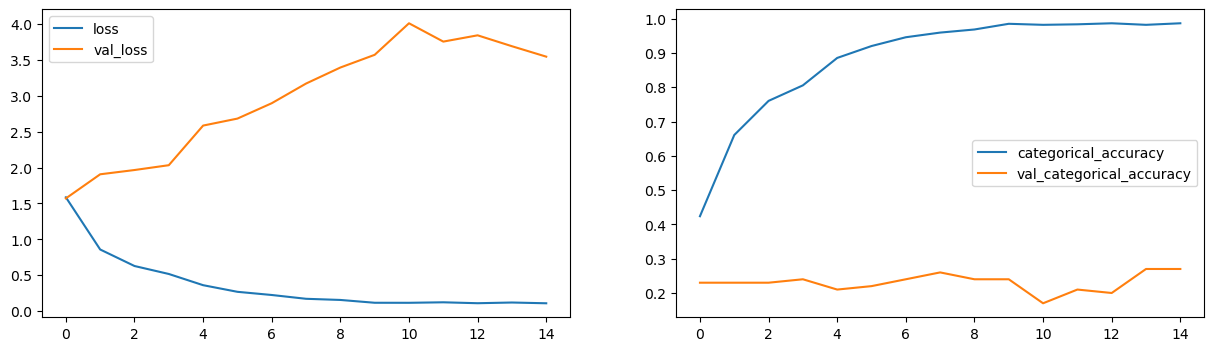

In [17]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [18]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [19]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/20

Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 1/34 [..............................] - ETA: 15:51 - loss: 2.4882 - categorical_accuracy: 0.2750
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 2/34 [>.............................] - ETA: 14:58 - loss: 2.4882 - categorical_accuracy: 0.2250
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 3/34 [=>............................] - ETA: 14:33 - loss: 2.4664 - categorical_accuracy: 0.2250
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 4/34 [==>...........................] - ETA: 14:02 - loss: 2.2920 - categorical_accuracy: 0.2562
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 5/34 [===>..........................] - ETA: 13:33 - loss: 2.1765 - categorical_accuracy: 0.2900
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 6/34 [====>.........................] - ETA: 13:06 - loss: 2.0878 - categorical_accuracy: 0.3083
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 7/34 [=====>........................] - ETA: 12:36 - loss: 2.1161 - categorical_accuracy: 0.3214
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 8/34 [======>.......................] - ETA: 12:08 - loss: 2.0157 - categorical_accuracy: 0.3562
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 9/34 [======>.......................] - ETA: 11:39 - loss: 1.9523 - categorical_accuracy: 0.3639
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


10/34 [=======>......................] - ETA: 11:10 - loss: 1.9773 - categorical_accuracy: 0.3650
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


11/34 [========>.....................] - ETA: 10:42 - loss: 1.9883 - categorical_accuracy: 0.3682
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


12/34 [=========>....................] - ETA: 10:13 - loss: 2.0005 - categorical_accuracy: 0.3604
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


13/34 [==========>...................] - ETA: 9:45 - loss: 1.9627 - categorical_accuracy: 0.3654 
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


14/34 [===========>..................] - ETA: 9:17 - loss: 1.9850 - categorical_accuracy: 0.3571
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


15/34 [============>.................] - ETA: 8:48 - loss: 1.9517 - categorical_accuracy: 0.3667
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


16/34 [=============>................] - ETA: 8:21 - loss: 1.9285 - categorical_accuracy: 0.3641
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


17/34 [==============>...............] - ETA: 7:53 - loss: 1.9390 - categorical_accuracy: 0.3706
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


18/34 [==============>...............] - ETA: 7:25 - loss: 1.9174 - categorical_accuracy: 0.3764
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


19/34 [===============>..............] - ETA: 6:57 - loss: 1.8920 - categorical_accuracy: 0.3855
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


20/34 [================>.............] - ETA: 6:29 - loss: 1.9084 - categorical_accuracy: 0.3812
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


21/34 [=================>............] - ETA: 6:01 - loss: 1.9197 - categorical_accuracy: 0.3821
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


22/34 [==================>...........] - ETA: 5:33 - loss: 1.9071 - categorical_accuracy: 0.3886
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


23/34 [===================>..........] - ETA: 5:05 - loss: 1.8875 - categorical_accuracy: 0.3913
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


24/34 [====================>.........] - ETA: 4:37 - loss: 1.8670 - categorical_accuracy: 0.3958
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


25/34 [=====================>........] - ETA: 4:09 - loss: 1.8561 - categorical_accuracy: 0.3960
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


26/34 [=====================>........] - ETA: 3:41 - loss: 1.8330 - categorical_accuracy: 0.4010
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


27/34 [======================>.......] - ETA: 3:14 - loss: 1.8264 - categorical_accuracy: 0.4065
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


28/34 [=======================>......] - ETA: 2:46 - loss: 1.8253 - categorical_accuracy: 0.4089
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


29/34 [========================>.....] - ETA: 2:18 - loss: 1.8252 - categorical_accuracy: 0.4095
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


30/34 [=========================>....] - ETA: 1:50 - loss: 1.8294 - categorical_accuracy: 0.4092
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


31/34 [==========================>...] - ETA: 1:23 - loss: 1.8172 - categorical_accuracy: 0.4105
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


32/34 [===========================>..] - ETA: 55s - loss: 1.8074 - categorical_accuracy: 0.4141 
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


33/34 [============================>.] - ETA: 27s - loss: 1.7916 - categorical_accuracy: 0.4182
Epoch 1: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


34/34 [==============================] - 935s 27s/step - loss: 1.7927 - categorical_accuracy: 0.4178 - val_loss: 3.6614 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20

Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 1/34 [..............................] - ETA: 15:10 - loss: 1.1432 - categorical_accuracy: 0.6500
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 2/34 [>.............................] - ETA: 14:46 - loss: 1.1397 - categorical_accuracy: 0.6500
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 3/34 [=>............................] - ETA: 14:16 - loss: 1.2156 - categorical_accuracy: 0.5833
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 4/34 [==>...........................] - ETA: 13:47 - loss: 1.4478 - categorical_accuracy: 0.5437
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 5/34 [===>..........................] - ETA: 13:18 - loss: 1.4441 - categorical_accuracy: 0.5450
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 6/34 [====>.........................] - ETA: 12:50 - loss: 1.3881 - categorical_accuracy: 0.5583
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 7/34 [=====>........................] - ETA: 12:23 - loss: 1.3353 - categorical_accuracy: 0.5607
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 8/34 [======>.......................] - ETA: 11:53 - loss: 1.3570 - categorical_accuracy: 0.5500
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 9/34 [======>.......................] - ETA: 11:26 - loss: 1.3379 - categorical_accuracy: 0.5528
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


10/34 [=======>......................] - ETA: 10:59 - loss: 1.3736 - categorical_accuracy: 0.5400
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


11/34 [========>.....................] - ETA: 10:31 - loss: 1.3688 - categorical_accuracy: 0.5364
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


12/34 [=========>....................] - ETA: 10:04 - loss: 1.3998 - categorical_accuracy: 0.5250
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


13/34 [==========>...................] - ETA: 9:37 - loss: 1.4102 - categorical_accuracy: 0.5288 
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


14/34 [===========>..................] - ETA: 9:09 - loss: 1.4066 - categorical_accuracy: 0.5304
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


15/34 [============>.................] - ETA: 8:42 - loss: 1.3775 - categorical_accuracy: 0.5350
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


16/34 [=============>................] - ETA: 8:15 - loss: 1.3480 - categorical_accuracy: 0.5422
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


17/34 [==============>...............] - ETA: 7:47 - loss: 1.3267 - categorical_accuracy: 0.5456
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


18/34 [==============>...............] - ETA: 7:20 - loss: 1.3238 - categorical_accuracy: 0.5472
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


19/34 [===============>..............] - ETA: 6:52 - loss: 1.3024 - categorical_accuracy: 0.5513
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


20/34 [================>.............] - ETA: 6:24 - loss: 1.2946 - categorical_accuracy: 0.5525
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


21/34 [=================>............] - ETA: 5:57 - loss: 1.2992 - categorical_accuracy: 0.5452
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


22/34 [==================>...........] - ETA: 5:30 - loss: 1.3011 - categorical_accuracy: 0.5477
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


23/34 [===================>..........] - ETA: 5:02 - loss: 1.2886 - categorical_accuracy: 0.5511
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


24/34 [====================>.........] - ETA: 4:35 - loss: 1.3052 - categorical_accuracy: 0.5510
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


25/34 [=====================>........] - ETA: 4:07 - loss: 1.3026 - categorical_accuracy: 0.5540
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


26/34 [=====================>........] - ETA: 3:40 - loss: 1.3010 - categorical_accuracy: 0.5558
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


27/34 [======================>.......] - ETA: 3:12 - loss: 1.2985 - categorical_accuracy: 0.5574
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


28/34 [=======================>......] - ETA: 2:45 - loss: 1.2897 - categorical_accuracy: 0.5598
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


29/34 [========================>.....] - ETA: 2:17 - loss: 1.2762 - categorical_accuracy: 0.5655
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


30/34 [=========================>....] - ETA: 1:50 - loss: 1.2661 - categorical_accuracy: 0.5650
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


31/34 [==========================>...] - ETA: 1:22 - loss: 1.2665 - categorical_accuracy: 0.5653
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


32/34 [===========================>..] - ETA: 55s - loss: 1.2666 - categorical_accuracy: 0.5672 
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


33/34 [============================>.] - ETA: 27s - loss: 1.2611 - categorical_accuracy: 0.5674
Epoch 2: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


34/34 [==============================] - 929s 27s/step - loss: 1.2653 - categorical_accuracy: 0.5664 - val_loss: 3.7654 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20

Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 1/34 [..............................] - ETA: 15:11 - loss: 1.0347 - categorical_accuracy: 0.6750
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 2/34 [>.............................] - ETA: 14:43 - loss: 1.3402 - categorical_accuracy: 0.5375
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 3/34 [=>............................] - ETA: 14:17 - loss: 1.3135 - categorical_accuracy: 0.5250
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 4/34 [==>...........................] - ETA: 13:52 - loss: 1.3300 - categorical_accuracy: 0.5250
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 5/34 [===>..........................] - ETA: 13:24 - loss: 1.5367 - categorical_accuracy: 0.4850
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 6/34 [====>.........................] - ETA: 12:56 - loss: 1.4897 - categorical_accuracy: 0.5000
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 7/34 [=====>........................] - ETA: 12:28 - loss: 1.5360 - categorical_accuracy: 0.4964
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 8/34 [======>.......................] - ETA: 12:00 - loss: 1.4672 - categorical_accuracy: 0.5219
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 9/34 [======>.......................] - ETA: 11:33 - loss: 1.4264 - categorical_accuracy: 0.5278
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


10/34 [=======>......................] - ETA: 11:06 - loss: 1.4150 - categorical_accuracy: 0.5275
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


11/34 [========>.....................] - ETA: 10:38 - loss: 1.4006 - categorical_accuracy: 0.5227
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


12/34 [=========>....................] - ETA: 10:10 - loss: 1.3969 - categorical_accuracy: 0.5250
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


13/34 [==========>...................] - ETA: 9:43 - loss: 1.3853 - categorical_accuracy: 0.5250 
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


14/34 [===========>..................] - ETA: 9:15 - loss: 1.3614 - categorical_accuracy: 0.5304
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


15/34 [============>.................] - ETA: 8:47 - loss: 1.3488 - categorical_accuracy: 0.5367
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


16/34 [=============>................] - ETA: 8:20 - loss: 1.3638 - categorical_accuracy: 0.5344
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


17/34 [==============>...............] - ETA: 7:52 - loss: 1.3536 - categorical_accuracy: 0.5397
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


18/34 [==============>...............] - ETA: 7:24 - loss: 1.3228 - categorical_accuracy: 0.5458
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


19/34 [===============>..............] - ETA: 6:56 - loss: 1.2987 - categorical_accuracy: 0.5500
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


20/34 [================>.............] - ETA: 6:28 - loss: 1.2925 - categorical_accuracy: 0.5512
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


21/34 [=================>............] - ETA: 6:01 - loss: 1.2792 - categorical_accuracy: 0.5536
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


22/34 [==================>...........] - ETA: 5:33 - loss: 1.2654 - categorical_accuracy: 0.5534
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


23/34 [===================>..........] - ETA: 5:05 - loss: 1.2507 - categorical_accuracy: 0.5576
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


24/34 [====================>.........] - ETA: 4:37 - loss: 1.2524 - categorical_accuracy: 0.5552
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


25/34 [=====================>........] - ETA: 4:10 - loss: 1.2495 - categorical_accuracy: 0.5590
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


26/34 [=====================>........] - ETA: 3:42 - loss: 1.2369 - categorical_accuracy: 0.5606
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


27/34 [======================>.......] - ETA: 3:14 - loss: 1.2315 - categorical_accuracy: 0.5602
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


28/34 [=======================>......] - ETA: 2:46 - loss: 1.2140 - categorical_accuracy: 0.5634
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


29/34 [========================>.....] - ETA: 2:18 - loss: 1.2099 - categorical_accuracy: 0.5612
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


30/34 [=========================>....] - ETA: 1:51 - loss: 1.2112 - categorical_accuracy: 0.5625
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


31/34 [==========================>...] - ETA: 1:23 - loss: 1.2011 - categorical_accuracy: 0.5669
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


32/34 [===========================>..] - ETA: 55s - loss: 1.2093 - categorical_accuracy: 0.5633 
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


33/34 [============================>.] - ETA: 27s - loss: 1.1945 - categorical_accuracy: 0.5674
Epoch 3: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


34/34 [==============================] - 936s 28s/step - loss: 1.1955 - categorical_accuracy: 0.5679 - val_loss: 4.7935 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/20

Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 1/34 [..............................] - ETA: 15:14 - loss: 1.0455 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 2/34 [>.............................] - ETA: 14:47 - loss: 1.1739 - categorical_accuracy: 0.6125
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 3/34 [=>............................] - ETA: 14:21 - loss: 1.2026 - categorical_accuracy: 0.5917
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 4/34 [==>...........................] - ETA: 13:52 - loss: 1.0963 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 5/34 [===>..........................] - ETA: 13:25 - loss: 1.0870 - categorical_accuracy: 0.6300
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 6/34 [====>.........................] - ETA: 12:57 - loss: 1.0298 - categorical_accuracy: 0.6500
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 7/34 [=====>........................] - ETA: 12:28 - loss: 1.0911 - categorical_accuracy: 0.6286
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 8/34 [======>.......................] - ETA: 12:03 - loss: 1.0607 - categorical_accuracy: 0.6313
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


 9/34 [======>.......................] - ETA: 11:35 - loss: 1.0529 - categorical_accuracy: 0.6194
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


10/34 [=======>......................] - ETA: 11:08 - loss: 1.0370 - categorical_accuracy: 0.6300
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


11/34 [========>.....................] - ETA: 10:40 - loss: 1.0310 - categorical_accuracy: 0.6295
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


12/34 [=========>....................] - ETA: 10:12 - loss: 1.0445 - categorical_accuracy: 0.6313
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


13/34 [==========>...................] - ETA: 9:44 - loss: 1.0586 - categorical_accuracy: 0.6288 
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


14/34 [===========>..................] - ETA: 9:16 - loss: 1.0807 - categorical_accuracy: 0.6232
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


15/34 [============>.................] - ETA: 8:49 - loss: 1.0859 - categorical_accuracy: 0.6233
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


16/34 [=============>................] - ETA: 8:21 - loss: 1.0840 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


17/34 [==============>...............] - ETA: 7:53 - loss: 1.0810 - categorical_accuracy: 0.6176
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


18/34 [==============>...............] - ETA: 7:25 - loss: 1.0566 - categorical_accuracy: 0.6222
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


19/34 [===============>..............] - ETA: 6:57 - loss: 1.0534 - categorical_accuracy: 0.6197
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


20/34 [================>.............] - ETA: 6:29 - loss: 1.0472 - categorical_accuracy: 0.6225
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


21/34 [=================>............] - ETA: 6:01 - loss: 1.0483 - categorical_accuracy: 0.6226
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


22/34 [==================>...........] - ETA: 5:33 - loss: 1.0616 - categorical_accuracy: 0.6193
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


23/34 [===================>..........] - ETA: 5:05 - loss: 1.0613 - categorical_accuracy: 0.6207
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


24/34 [====================>.........] - ETA: 4:37 - loss: 1.0621 - categorical_accuracy: 0.6229
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


25/34 [=====================>........] - ETA: 4:10 - loss: 1.0693 - categorical_accuracy: 0.6200
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


26/34 [=====================>........] - ETA: 3:42 - loss: 1.0691 - categorical_accuracy: 0.6240
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


27/34 [======================>.......] - ETA: 3:14 - loss: 1.0621 - categorical_accuracy: 0.6287
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


28/34 [=======================>......] - ETA: 2:46 - loss: 1.0447 - categorical_accuracy: 0.6330
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


29/34 [========================>.....] - ETA: 2:18 - loss: 1.0333 - categorical_accuracy: 0.6379
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


30/34 [=========================>....] - ETA: 1:51 - loss: 1.0490 - categorical_accuracy: 0.6350
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


31/34 [==========================>...] - ETA: 1:23 - loss: 1.0458 - categorical_accuracy: 0.6347
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


32/34 [===========================>..] - ETA: 55s - loss: 1.0512 - categorical_accuracy: 0.6352 
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


33/34 [============================>.] - ETA: 27s - loss: 1.0442 - categorical_accuracy: 0.6356
Epoch 4: saving model to model_init_2023-05-1714_15_12.881747\
INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1714_15_12.881747\assets


34/34 [==============================] - 935s 27s/step - loss: 1.0475 - categorical_accuracy: 0.6357 - val_loss: 5.7294 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 5/20


KeyboardInterrupt: 

In [20]:
plot(history_model2)

NameError: name 'history_model2' is not defined

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 91%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - reducing the number of parameters

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(dense_neurons=64,dropout=0.25)
conv_3d3_model.summary()

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

In [ ]:
plot(history_model3)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 4 - CNN- LSTM Model

In [21]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model4=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20

Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 25:39 - loss: 1.6708 - categorical_accuracy: 0.1500
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:02 - loss: 1.6039 - categorical_accuracy: 0.2375 
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 5:50 - loss: 1.6284 - categorical_accuracy: 0.2333
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:33 - loss: 1.6553 - categorical_accuracy: 0.2375
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:21 - loss: 1.6556 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:11 - loss: 1.6322 - categorical_accuracy: 0.2625
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:00 - loss: 1.6126 - categorical_accuracy: 0.2857
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 4:49 - loss: 1.5906 - categorical_accuracy: 0.2937
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:38 - loss: 1.5770 - categorical_accuracy: 0.3083
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:27 - loss: 1.5577 - categorical_accuracy: 0.3250
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:16 - loss: 1.5527 - categorical_accuracy: 0.3182
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:04 - loss: 1.5395 - categorical_accuracy: 0.3271
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 3:53 - loss: 1.5310 - categorical_accuracy: 0.3346
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:42 - loss: 1.5123 - categorical_accuracy: 0.3446
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:31 - loss: 1.5139 - categorical_accuracy: 0.3433
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:20 - loss: 1.5067 - categorical_accuracy: 0.3500
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:09 - loss: 1.5041 - categorical_accuracy: 0.3456
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 2:58 - loss: 1.4973 - categorical_accuracy: 0.3486
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:47 - loss: 1.4879 - categorical_accuracy: 0.3539
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:36 - loss: 1.4696 - categorical_accuracy: 0.3638
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:25 - loss: 1.4528 - categorical_accuracy: 0.3726
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:14 - loss: 1.4455 - categorical_accuracy: 0.3784
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:03 - loss: 1.4351 - categorical_accuracy: 0.3848
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:52 - loss: 1.4226 - categorical_accuracy: 0.3906
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:41 - loss: 1.4091 - categorical_accuracy: 0.3980
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:29 - loss: 1.4087 - categorical_accuracy: 0.3971
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:18 - loss: 1.4011 - categorical_accuracy: 0.4037
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:07 - loss: 1.3928 - categorical_accuracy: 0.4098
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 56s - loss: 1.3784 - categorical_accuracy: 0.4216 
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\


C:\Users\fv1\AppData\Local\Temp\ipykernel_27376\3543782872.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 45s - loss: 1.3659 - categorical_accuracy: 0.4283
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 33s - loss: 1.3592 - categorical_accuracy: 0.4306
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 22s - loss: 1.3562 - categorical_accuracy: 0.4328
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 11s - loss: 1.3476 - categorical_accuracy: 0.4386
Epoch 1: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 424s 11s/step - loss: 1.3468 - categorical_accuracy: 0.4397 - val_loss: 1.6086 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20

Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:23 - loss: 1.3332 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 5:53 - loss: 1.0125 - categorical_accuracy: 0.6750
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 5:52 - loss: 1.0132 - categorical_accuracy: 0.6667
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:42 - loss: 1.0084 - categorical_accuracy: 0.6313
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:30 - loss: 1.0953 - categorical_accuracy: 0.5750
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:21 - loss: 1.1411 - categorical_accuracy: 0.5375
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:11 - loss: 1.1378 - categorical_accuracy: 0.5464
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 4:58 - loss: 1.0966 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:48 - loss: 1.0652 - categorical_accuracy: 0.5833
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:36 - loss: 1.0701 - categorical_accuracy: 0.5800
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:16 - loss: 1.0668 - categorical_accuracy: 0.5818
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 3:56 - loss: 1.0817 - categorical_accuracy: 0.5833
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 3:39 - loss: 1.0937 - categorical_accuracy: 0.5827
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:23 - loss: 1.0635 - categorical_accuracy: 0.6018
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:12 - loss: 1.0641 - categorical_accuracy: 0.6033
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:03 - loss: 1.0689 - categorical_accuracy: 0.6047
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 2:54 - loss: 1.0642 - categorical_accuracy: 0.6074
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 2:45 - loss: 1.0577 - categorical_accuracy: 0.6083
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:35 - loss: 1.0589 - categorical_accuracy: 0.6092
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:26 - loss: 1.0575 - categorical_accuracy: 0.6125
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:16 - loss: 1.0569 - categorical_accuracy: 0.6155
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:06 - loss: 1.0582 - categorical_accuracy: 0.6125
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 1:56 - loss: 1.0419 - categorical_accuracy: 0.6174
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:46 - loss: 1.0460 - categorical_accuracy: 0.6167
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:36 - loss: 1.0401 - categorical_accuracy: 0.6170
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:25 - loss: 1.0316 - categorical_accuracy: 0.6202
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:15 - loss: 1.0185 - categorical_accuracy: 0.6259
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:04 - loss: 1.0276 - categorical_accuracy: 0.6196
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 54s - loss: 1.0297 - categorical_accuracy: 0.6164 
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 43s - loss: 1.0282 - categorical_accuracy: 0.6167
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 32s - loss: 1.0423 - categorical_accuracy: 0.6145
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 21s - loss: 1.0425 - categorical_accuracy: 0.6156
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 10s - loss: 1.0440 - categorical_accuracy: 0.6129
Epoch 2: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 376s 11s/step - loss: 1.0478 - categorical_accuracy: 0.6116 - val_loss: 2.0280 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20

Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:17 - loss: 0.9887 - categorical_accuracy: 0.5250
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:16 - loss: 0.8914 - categorical_accuracy: 0.6250
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 5:58 - loss: 0.9328 - categorical_accuracy: 0.6083
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:52 - loss: 0.8866 - categorical_accuracy: 0.6313
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:39 - loss: 0.8640 - categorical_accuracy: 0.6400
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:27 - loss: 0.8724 - categorical_accuracy: 0.6458
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:15 - loss: 0.8475 - categorical_accuracy: 0.6714
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:03 - loss: 0.8394 - categorical_accuracy: 0.6750
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:51 - loss: 0.8568 - categorical_accuracy: 0.6556
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:39 - loss: 0.8521 - categorical_accuracy: 0.6650
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:26 - loss: 0.8575 - categorical_accuracy: 0.6636
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:15 - loss: 0.8485 - categorical_accuracy: 0.6708
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:03 - loss: 0.8403 - categorical_accuracy: 0.6692
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:51 - loss: 0.8350 - categorical_accuracy: 0.6714
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:39 - loss: 0.8273 - categorical_accuracy: 0.6783
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:28 - loss: 0.8414 - categorical_accuracy: 0.6719
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:16 - loss: 0.8382 - categorical_accuracy: 0.6706
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:04 - loss: 0.8323 - categorical_accuracy: 0.6736
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:53 - loss: 0.8304 - categorical_accuracy: 0.6763
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:42 - loss: 0.8302 - categorical_accuracy: 0.6775
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:30 - loss: 0.8325 - categorical_accuracy: 0.6786
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:18 - loss: 0.8234 - categorical_accuracy: 0.6864
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:07 - loss: 0.8147 - categorical_accuracy: 0.6902
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:55 - loss: 0.8274 - categorical_accuracy: 0.6875
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:44 - loss: 0.8357 - categorical_accuracy: 0.6860
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:32 - loss: 0.8372 - categorical_accuracy: 0.6865
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:21 - loss: 0.8348 - categorical_accuracy: 0.6880
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:09 - loss: 0.8192 - categorical_accuracy: 0.6964
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 57s - loss: 0.8250 - categorical_accuracy: 0.6897 
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 46s - loss: 0.8152 - categorical_accuracy: 0.6933
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 34s - loss: 0.8291 - categorical_accuracy: 0.6903
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 23s - loss: 0.8341 - categorical_accuracy: 0.6883
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 11s - loss: 0.8280 - categorical_accuracy: 0.6909
Epoch 3: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 398s 12s/step - loss: 0.8249 - categorical_accuracy: 0.6923 - val_loss: 1.7586 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 4/20

Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:14 - loss: 0.8007 - categorical_accuracy: 0.6500
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:29 - loss: 0.9452 - categorical_accuracy: 0.6500
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 6:11 - loss: 0.8580 - categorical_accuracy: 0.6750
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:58 - loss: 0.7900 - categorical_accuracy: 0.7063
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:45 - loss: 0.7287 - categorical_accuracy: 0.7200
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:32 - loss: 0.6753 - categorical_accuracy: 0.7458
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:21 - loss: 0.6545 - categorical_accuracy: 0.7464
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:09 - loss: 0.6182 - categorical_accuracy: 0.7625
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:58 - loss: 0.6189 - categorical_accuracy: 0.7639
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:46 - loss: 0.6537 - categorical_accuracy: 0.7600
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:34 - loss: 0.6802 - categorical_accuracy: 0.7500
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:22 - loss: 0.6572 - categorical_accuracy: 0.7604
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:09 - loss: 0.6642 - categorical_accuracy: 0.7500
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:57 - loss: 0.6580 - categorical_accuracy: 0.7536
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:45 - loss: 0.6717 - categorical_accuracy: 0.7467
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:34 - loss: 0.6764 - categorical_accuracy: 0.7469
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:21 - loss: 0.6875 - categorical_accuracy: 0.7441
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:09 - loss: 0.6832 - categorical_accuracy: 0.7458
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:57 - loss: 0.7024 - categorical_accuracy: 0.7382
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:45 - loss: 0.6976 - categorical_accuracy: 0.7387
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:33 - loss: 0.6942 - categorical_accuracy: 0.7393
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:22 - loss: 0.6950 - categorical_accuracy: 0.7409
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:10 - loss: 0.6961 - categorical_accuracy: 0.7402
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:58 - loss: 0.6961 - categorical_accuracy: 0.7385
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:46 - loss: 0.7101 - categorical_accuracy: 0.7330
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:34 - loss: 0.7110 - categorical_accuracy: 0.7327
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:22 - loss: 0.7114 - categorical_accuracy: 0.7315
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:10 - loss: 0.7205 - categorical_accuracy: 0.7295
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 58s - loss: 0.7203 - categorical_accuracy: 0.7310 
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 47s - loss: 0.7168 - categorical_accuracy: 0.7317
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 35s - loss: 0.7185 - categorical_accuracy: 0.7290
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 23s - loss: 0.7257 - categorical_accuracy: 0.7258
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 11s - loss: 0.7175 - categorical_accuracy: 0.7288
Epoch 4: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 405s 12s/step - loss: 0.7164 - categorical_accuracy: 0.7285 - val_loss: 2.4791 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/20

Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:35 - loss: 0.6048 - categorical_accuracy: 0.7250
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:26 - loss: 0.6456 - categorical_accuracy: 0.6875
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 6:08 - loss: 0.6623 - categorical_accuracy: 0.6750
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:59 - loss: 0.6390 - categorical_accuracy: 0.7000
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:47 - loss: 0.6808 - categorical_accuracy: 0.6800
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:34 - loss: 0.6348 - categorical_accuracy: 0.7042
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:21 - loss: 0.6400 - categorical_accuracy: 0.7107
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:07 - loss: 0.6076 - categorical_accuracy: 0.7281
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:56 - loss: 0.6032 - categorical_accuracy: 0.7389
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:44 - loss: 0.6167 - categorical_accuracy: 0.7325
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:32 - loss: 0.5957 - categorical_accuracy: 0.7409
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:18 - loss: 0.5973 - categorical_accuracy: 0.7479
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:07 - loss: 0.6005 - categorical_accuracy: 0.7481
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:54 - loss: 0.5896 - categorical_accuracy: 0.7571
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:42 - loss: 0.5999 - categorical_accuracy: 0.7517
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:31 - loss: 0.6059 - categorical_accuracy: 0.7516
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:19 - loss: 0.5888 - categorical_accuracy: 0.7603
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:07 - loss: 0.5865 - categorical_accuracy: 0.7611
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:56 - loss: 0.5808 - categorical_accuracy: 0.7645
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:44 - loss: 0.5759 - categorical_accuracy: 0.7675
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:32 - loss: 0.5802 - categorical_accuracy: 0.7655
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:20 - loss: 0.5676 - categorical_accuracy: 0.7716
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:08 - loss: 0.5607 - categorical_accuracy: 0.7761
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:57 - loss: 0.5476 - categorical_accuracy: 0.7844
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:45 - loss: 0.5652 - categorical_accuracy: 0.7780
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:33 - loss: 0.5511 - categorical_accuracy: 0.7846
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:22 - loss: 0.5426 - categorical_accuracy: 0.7880
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:10 - loss: 0.5412 - categorical_accuracy: 0.7893
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 58s - loss: 0.5368 - categorical_accuracy: 0.7905 
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 46s - loss: 0.5354 - categorical_accuracy: 0.7933
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 35s - loss: 0.5367 - categorical_accuracy: 0.7919
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 23s - loss: 0.5360 - categorical_accuracy: 0.7922
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 11s - loss: 0.5327 - categorical_accuracy: 0.7955
Epoch 5: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - ETA: 0s - loss: 0.5365 - categorical_accuracy: 0.7941 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
34/34 [==============================] - 403s 12s/step - loss: 0.5365 - categorical_accuracy: 0.7941 - val_loss: 2.2229 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 6/20

Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:15 - loss: 0.3934 - categorical_accuracy: 0.8750
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:11 - loss: 0.5534 - categorical_accuracy: 0.7875
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 5:59 - loss: 0.4733 - categorical_accuracy: 0.8333
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:52 - loss: 0.4611 - categorical_accuracy: 0.8562
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:38 - loss: 0.4194 - categorical_accuracy: 0.8750
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:25 - loss: 0.4443 - categorical_accuracy: 0.8625
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:13 - loss: 0.4617 - categorical_accuracy: 0.8571
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:04 - loss: 0.4435 - categorical_accuracy: 0.8625
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:52 - loss: 0.4554 - categorical_accuracy: 0.8528
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:41 - loss: 0.4636 - categorical_accuracy: 0.8375
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:30 - loss: 0.4482 - categorical_accuracy: 0.8409
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:18 - loss: 0.4463 - categorical_accuracy: 0.8396
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:06 - loss: 0.4416 - categorical_accuracy: 0.8423
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:55 - loss: 0.4338 - categorical_accuracy: 0.8446
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:43 - loss: 0.4274 - categorical_accuracy: 0.8467
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:32 - loss: 0.4180 - categorical_accuracy: 0.8531
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:21 - loss: 0.4139 - categorical_accuracy: 0.8559
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:10 - loss: 0.4219 - categorical_accuracy: 0.8514
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:59 - loss: 0.4174 - categorical_accuracy: 0.8500
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:47 - loss: 0.4141 - categorical_accuracy: 0.8525
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:35 - loss: 0.4101 - categorical_accuracy: 0.8536
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:23 - loss: 0.3986 - categorical_accuracy: 0.8602
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:11 - loss: 0.3926 - categorical_accuracy: 0.8630
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:59 - loss: 0.3919 - categorical_accuracy: 0.8615
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:47 - loss: 0.4084 - categorical_accuracy: 0.8560
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:35 - loss: 0.4026 - categorical_accuracy: 0.8587
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:23 - loss: 0.4052 - categorical_accuracy: 0.8593
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:11 - loss: 0.3996 - categorical_accuracy: 0.8607
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 59s - loss: 0.3916 - categorical_accuracy: 0.8647 
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 47s - loss: 0.3928 - categorical_accuracy: 0.8617
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 35s - loss: 0.3853 - categorical_accuracy: 0.8653
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 23s - loss: 0.3781 - categorical_accuracy: 0.8680
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 11s - loss: 0.3777 - categorical_accuracy: 0.8674
Epoch 6: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 410s 12s/step - loss: 0.3769 - categorical_accuracy: 0.8680 - val_loss: 2.3537 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 7/20

Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:19 - loss: 0.5970 - categorical_accuracy: 0.7500
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:14 - loss: 0.5453 - categorical_accuracy: 0.7625
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 6:01 - loss: 0.4259 - categorical_accuracy: 0.8333
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:49 - loss: 0.3771 - categorical_accuracy: 0.8625
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:42 - loss: 0.3795 - categorical_accuracy: 0.8550
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:30 - loss: 0.3747 - categorical_accuracy: 0.8667
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:18 - loss: 0.3707 - categorical_accuracy: 0.8607
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:05 - loss: 0.3590 - categorical_accuracy: 0.8719
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:54 - loss: 0.3536 - categorical_accuracy: 0.8750
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:42 - loss: 0.3353 - categorical_accuracy: 0.8850
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:30 - loss: 0.3239 - categorical_accuracy: 0.8909
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:20 - loss: 0.3103 - categorical_accuracy: 0.8979
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:09 - loss: 0.3219 - categorical_accuracy: 0.8923
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 4:02 - loss: 0.3232 - categorical_accuracy: 0.8875
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:49 - loss: 0.3143 - categorical_accuracy: 0.8917
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:37 - loss: 0.3079 - categorical_accuracy: 0.8969
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:25 - loss: 0.3028 - categorical_accuracy: 0.8985
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:12 - loss: 0.3019 - categorical_accuracy: 0.9014
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 3:01 - loss: 0.3009 - categorical_accuracy: 0.9000
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:48 - loss: 0.3076 - categorical_accuracy: 0.8963
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:36 - loss: 0.3128 - categorical_accuracy: 0.8929
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:24 - loss: 0.3145 - categorical_accuracy: 0.8932
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:12 - loss: 0.3092 - categorical_accuracy: 0.8946
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 2:00 - loss: 0.3104 - categorical_accuracy: 0.8917
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:48 - loss: 0.3028 - categorical_accuracy: 0.8960
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:36 - loss: 0.3016 - categorical_accuracy: 0.8952
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:24 - loss: 0.2956 - categorical_accuracy: 0.8972
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:12 - loss: 0.2949 - categorical_accuracy: 0.8964
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 1:00 - loss: 0.2886 - categorical_accuracy: 0.9000
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 48s - loss: 0.2952 - categorical_accuracy: 0.8958 
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 36s - loss: 0.2923 - categorical_accuracy: 0.8976
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 24s - loss: 0.2938 - categorical_accuracy: 0.8969
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 12s - loss: 0.2911 - categorical_accuracy: 0.8985
Epoch 7: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 413s 12s/step - loss: 0.2945 - categorical_accuracy: 0.8974 - val_loss: 2.2655 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 8/20

Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:40 - loss: 0.2351 - categorical_accuracy: 0.9000
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:25 - loss: 0.3356 - categorical_accuracy: 0.8375
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 6:19 - loss: 0.3088 - categorical_accuracy: 0.8583
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 6:04 - loss: 0.3317 - categorical_accuracy: 0.8562
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:50 - loss: 0.3443 - categorical_accuracy: 0.8550
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:37 - loss: 0.3295 - categorical_accuracy: 0.8625
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:22 - loss: 0.3088 - categorical_accuracy: 0.8786
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:11 - loss: 0.3056 - categorical_accuracy: 0.8844
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:59 - loss: 0.2940 - categorical_accuracy: 0.8889
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:47 - loss: 0.2993 - categorical_accuracy: 0.8850
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\


C:\Users\fv1\AppData\Local\Temp\ipykernel_27376\3543782872.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:35 - loss: 0.2864 - categorical_accuracy: 0.8909
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:22 - loss: 0.2859 - categorical_accuracy: 0.8938
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:11 - loss: 0.2850 - categorical_accuracy: 0.8942
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:59 - loss: 0.2848 - categorical_accuracy: 0.8982
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:46 - loss: 0.2757 - categorical_accuracy: 0.9000
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:34 - loss: 0.2683 - categorical_accuracy: 0.9047
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:25 - loss: 0.2696 - categorical_accuracy: 0.9044
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:15 - loss: 0.2649 - categorical_accuracy: 0.9042
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 3:03 - loss: 0.2684 - categorical_accuracy: 0.9039
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:50 - loss: 0.2794 - categorical_accuracy: 0.9025
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:38 - loss: 0.2743 - categorical_accuracy: 0.9060
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:25 - loss: 0.2718 - categorical_accuracy: 0.9091
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:13 - loss: 0.2684 - categorical_accuracy: 0.9120
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 2:01 - loss: 0.2713 - categorical_accuracy: 0.9083
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:49 - loss: 0.2677 - categorical_accuracy: 0.9110
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:36 - loss: 0.2634 - categorical_accuracy: 0.9125
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:24 - loss: 0.2601 - categorical_accuracy: 0.9130
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:12 - loss: 0.2569 - categorical_accuracy: 0.9143
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


29/34 [========================>.....] - ETA: 1:00 - loss: 0.2543 - categorical_accuracy: 0.9155
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


30/34 [=========================>....] - ETA: 48s - loss: 0.2558 - categorical_accuracy: 0.9133 
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


31/34 [==========================>...] - ETA: 36s - loss: 0.2567 - categorical_accuracy: 0.9137
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


32/34 [===========================>..] - ETA: 24s - loss: 0.2521 - categorical_accuracy: 0.9156
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


33/34 [============================>.] - ETA: 12s - loss: 0.2513 - categorical_accuracy: 0.9167
Epoch 8: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


34/34 [==============================] - 418s 12s/step - loss: 0.2508 - categorical_accuracy: 0.9170 - val_loss: 2.2044 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 9/20

Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 1/34 [..............................] - ETA: 6:24 - loss: 0.3209 - categorical_accuracy: 0.8500
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 2/34 [>.............................] - ETA: 6:32 - loss: 0.2397 - categorical_accuracy: 0.9000
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 3/34 [=>............................] - ETA: 6:15 - loss: 0.1934 - categorical_accuracy: 0.9250
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 4/34 [==>...........................] - ETA: 5:54 - loss: 0.2490 - categorical_accuracy: 0.9125
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 5/34 [===>..........................] - ETA: 5:42 - loss: 0.2425 - categorical_accuracy: 0.9150
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 6/34 [====>.........................] - ETA: 5:28 - loss: 0.2237 - categorical_accuracy: 0.9250
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 7/34 [=====>........................] - ETA: 5:14 - loss: 0.2477 - categorical_accuracy: 0.9214
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 8/34 [======>.......................] - ETA: 5:06 - loss: 0.2332 - categorical_accuracy: 0.9250
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


 9/34 [======>.......................] - ETA: 4:54 - loss: 0.2278 - categorical_accuracy: 0.9278
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


10/34 [=======>......................] - ETA: 4:41 - loss: 0.2287 - categorical_accuracy: 0.9300
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


11/34 [========>.....................] - ETA: 4:30 - loss: 0.2165 - categorical_accuracy: 0.9364
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


12/34 [=========>....................] - ETA: 4:19 - loss: 0.2082 - categorical_accuracy: 0.9396
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


13/34 [==========>...................] - ETA: 4:06 - loss: 0.2097 - categorical_accuracy: 0.9365
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


14/34 [===========>..................] - ETA: 3:55 - loss: 0.2004 - categorical_accuracy: 0.9411
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


15/34 [============>.................] - ETA: 3:43 - loss: 0.1988 - categorical_accuracy: 0.9417
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


16/34 [=============>................] - ETA: 3:31 - loss: 0.1914 - categorical_accuracy: 0.9453
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


17/34 [==============>...............] - ETA: 3:19 - loss: 0.2031 - categorical_accuracy: 0.9382
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


18/34 [==============>...............] - ETA: 3:07 - loss: 0.2086 - categorical_accuracy: 0.9347
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


19/34 [===============>..............] - ETA: 2:55 - loss: 0.2139 - categorical_accuracy: 0.9316
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


20/34 [================>.............] - ETA: 2:44 - loss: 0.2090 - categorical_accuracy: 0.9350
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


21/34 [=================>............] - ETA: 2:32 - loss: 0.2052 - categorical_accuracy: 0.9369
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


22/34 [==================>...........] - ETA: 2:20 - loss: 0.2073 - categorical_accuracy: 0.9364
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


23/34 [===================>..........] - ETA: 2:08 - loss: 0.2045 - categorical_accuracy: 0.9359
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


24/34 [====================>.........] - ETA: 1:57 - loss: 0.2059 - categorical_accuracy: 0.9354
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


25/34 [=====================>........] - ETA: 1:45 - loss: 0.2020 - categorical_accuracy: 0.9380
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


26/34 [=====================>........] - ETA: 1:33 - loss: 0.1982 - categorical_accuracy: 0.9394
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


27/34 [======================>.......] - ETA: 1:22 - loss: 0.1971 - categorical_accuracy: 0.9389
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\
INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


INFO:tensorflow:Assets written to: model_init_2023-05-1715_18_55.563885\assets


28/34 [=======================>......] - ETA: 1:10 - loss: 0.1997 - categorical_accuracy: 0.9384
Epoch 9: saving model to model_init_2023-05-1715_18_55.563885\


In [ ]:
plot(history_model4)

##### For CNN - LSTM model we get a best validation accuracy of 75%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# Model 5 - CNN LSTM with GRU - Similar to Model 9

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model5=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

In [ ]:
plot(history_model5)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

In [ ]:
from keras.applications import mobilenet

# Model 6 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model6=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

In [ ]:
plot(history_model6)

# Consolidated Final Models

In [ ]:
##add tablr of all model

# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('conv3d_model-10-0.39118-0.86425-0.59927-0.86000.h5')

In [ ]:
test_generator=ModelConv3D2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

## Model Overview

| Model Name     | Model Type | Number of parameters | Augment Data | Model Size(in MB) | Highest Validation accuracy | Corres-ponding Training accuracy | Observations                                                                                                                                                               |
|----------------|------------|----------------------|--------------|-------------------|-----------------------------|----------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| conv_3d1_model | Conv3D     | 1,117,061            | No           | NA                | 78%                         | 99%                              | Model is over-fitting. Augment data using cropping                                                                                                                         |
| conv_3d2_model | Conv3D     | 3,638,981            | Yes          | 43.8              | 85%                         | 91%                              | Model is not over-fitting. Next we will try to reduce the parameter size. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002 |

| conv_3d3_model | Conv3D     | 504,709              | Yes          | 6.15              | 77%                         | 85%                              |                                                                                                                                                                    
| rnn_cnn1_model | CNN-LSTM   | 1,657,445            | Yes          | 20                | 75%                         | 92%                              | Model is over-fitting. Let’s try reducing the number of layers in next iteration                                                                                           |

## Models with More Data Augmentation
## Transfer Learning Models (CNN + RNN)
### Mobilenet model is considered as its parameter size is less compared to Inception and Resnet models

| Model Name        | Number of parameters | Augment Data | Model Size(in MB) | Highest validation accuracy | Corres-ponding Training accuracy | Observations                                                                                                                                     |
|-------------------|----------------------|--------------|-------------------|-----------------------------|----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| rnn_cnn_tl_model  | 3,840,453            | Yes          | 20.4              | 56%                         | 85%                              | For this experiment, Mobilenet layer weights are not trained. Validation accuracy is very poor. So let’s train mobilenet layer’s weights as well |
| rnn_cnn_tl2_model | 3,692,869            | Yes          | 42.3              | 97%                         | 99%                              | We get a better accuracy on training mobilenet layer’s weights as well.                                                                          |
